# ***REMOVE SHREK***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
import shutil

SCRIPT_DIR = os.getcwd()
datasets_path = os.path.join(SCRIPT_DIR, os.pardir, "an2dl2526c2")
DATASET_PATH = os.path.join(datasets_path, "train_unmasked_nogoo")

TEMP_DIR = os.path.join(SCRIPT_DIR, "temp")
SHREK_DIR = os.path.join(TEMP_DIR, "shrek")
TISSUE_DIR = os.path.join(TEMP_DIR, "tissue")

# --- CLEANUP LOGIC ---
os.makedirs(SHREK_DIR, exist_ok=True)
os.makedirs(TISSUE_DIR, exist_ok=True)

def clear_folder_contents(folder_path):
    """Removes all files inside a folder without deleting the folder itself."""
    if not os.path.exists(folder_path):
        return
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

clear_folder_contents(SHREK_DIR)
clear_folder_contents(TISSUE_DIR)
# ---------------------

# Threshold: Image must be at least 95% Green to be Shrek
RATIO_THRESHOLD =0.0125

UPPER_HUE_GREEN = 84
LOWER_HUE_GREEN = 20

UPPER_SAT_GREEN = 255
LOWER_SAT_GREEN = 45

UPPER_VAL_GREEN = 255
LOWER_VAL_GREEN = 0

In [195]:
def filter_bright_green_areas(image, lg_H=LOWER_HUE_GREEN, lg_S=LOWER_SAT_GREEN, lg_V=LOWER_VAL_GREEN, ug_H=UPPER_HUE_GREEN, ug_S=UPPER_SAT_GREEN, ug_V=UPPER_VAL_GREEN, dilate_iterations=2):
    """
    Filters out bright green areas from the input image with improved residual removal.
    
    Args:
        image: Input image in RGB format (0-1 range)
        lg_H, lg_S, lg_V: Lower bounds for HSV green detection
        ug_H, ug_S, ug_V: Upper bounds for HSV green detection
        dilate_iterations: Number of dilation iterations to expand mask (removes edge artifacts)
    """

    # Convert from RGB (0-1) to BGR (0-255) for OpenCV
    original_bgr = (image * 255).astype(np.uint8)[..., ::-1]

    # 1. Convert to HSV (Hue, Saturation, Value)
    hsv = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2HSV)

    # 2. Define the "Bright Green" Range
    lower_green = (lg_H, lg_S, lg_V)
    upper_green = (ug_H, ug_S, ug_V)

    # Create the initial mask
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # 3. Morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # OPEN: Remove small noise
    clean_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # DILATE: Expand the mask to catch edge artifacts and residuals
    # This ensures we remove green pixels at the boundaries
    if dilate_iterations > 0:
        clean_mask = cv2.dilate(clean_mask, kernel, iterations=dilate_iterations)

    # 4. Additional step: Detect any remaining green-ish pixels
    # Create a more aggressive mask for subtle green tones
    lower_green_subtle = (max(0, lg_H - 10), max(0, lg_S - 10), 0)
    upper_green_subtle = (min(180, ug_H + 10), 255, 255)
    subtle_mask = cv2.inRange(hsv, lower_green_subtle, upper_green_subtle)
    
    # Only keep subtle green pixels that are near the main green area
    subtle_mask = cv2.morphologyEx(subtle_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Combine masks
    combined_mask = cv2.bitwise_or(clean_mask, subtle_mask)

    # 5. Invert mask to keep the useful parts
    mask_inv = cv2.bitwise_not(combined_mask)

    # 6. Apply the mask
    result_bgr = cv2.bitwise_and(original_bgr, original_bgr, mask=mask_inv)

    return result_bgr, combined_mask

# =========================================================

def analyze_dataset(directory):
    shrek_images = []
    tissue_images = []
    
    image_files = glob.glob(os.path.join(directory, 'img_*.png'))
    print(f"Found {len(image_files)} images in {directory}")

    for f in image_files:
        try:
            # Load image (BGR)
            img = cv2.imread(f)
            if img is None: continue
            
            # Prepare image for the new filter: Convert BGR to RGB (0-1 float)
            img_rgb_norm = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            
            # Apply Filter
            result_bgr, mask = filter_bright_green_areas(img_rgb_norm, lg_H=LOWER_HUE_GREEN, lg_S=LOWER_SAT_GREEN, lg_V=LOWER_VAL_GREEN, ug_H=UPPER_HUE_GREEN, ug_S=UPPER_SAT_GREEN, ug_V=UPPER_VAL_GREEN, dilate_iterations=2)
            
            # Calculate Ratio of Green Pixels from the combined mask
            total_pixels = img.shape[0] * img.shape[1]
            green_pixels = np.count_nonzero(mask)
            ratio = green_pixels / total_pixels
            
            # Convert BGR to RGB for plotting
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            entry = {
                'name': os.path.basename(f), 
                'path': f,
                'img': img_rgb, 
                'ratio': ratio,
                'mask': mask
            }

            # === CLASSIFICATION LOGIC ===
            if ratio > RATIO_THRESHOLD:
                shrek_images.append(entry)
            else:
                tissue_images.append(entry)
                
        except Exception as e:
            print(f"Skipping {f}: {e}")

    return shrek_images, tissue_images



Found 1412 images in d:\POLIMI\AN2DL\AN2DL_CH_2\Scripts\..\an2dl2526c2\train_data
Classified 253 as Shrek
Classified 1159 as Tissue
Saving 253 Shrek images to d:\POLIMI\AN2DL\AN2DL_CH_2\Scripts\temp\shrek...
Saving 1159 Tissue images to d:\POLIMI\AN2DL\AN2DL_CH_2\Scripts\temp\tissue...


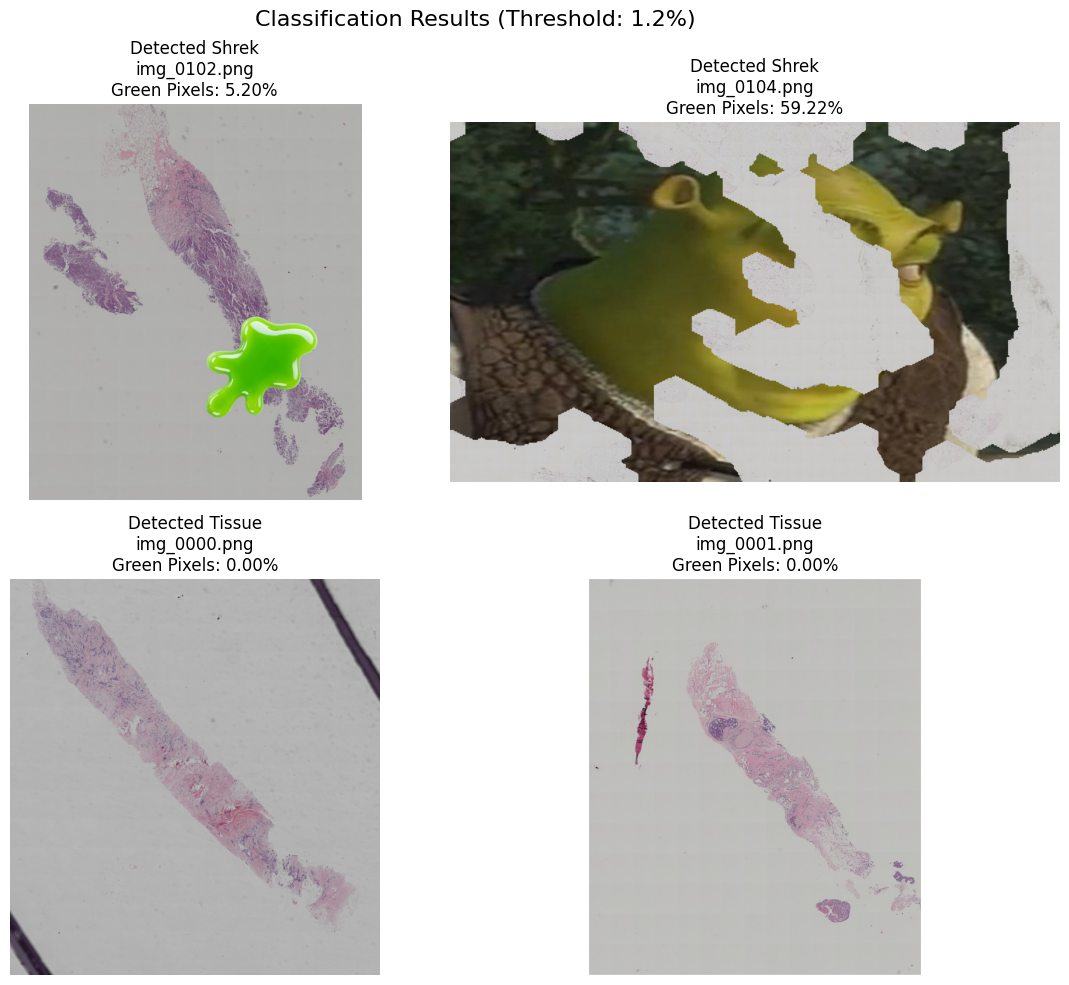

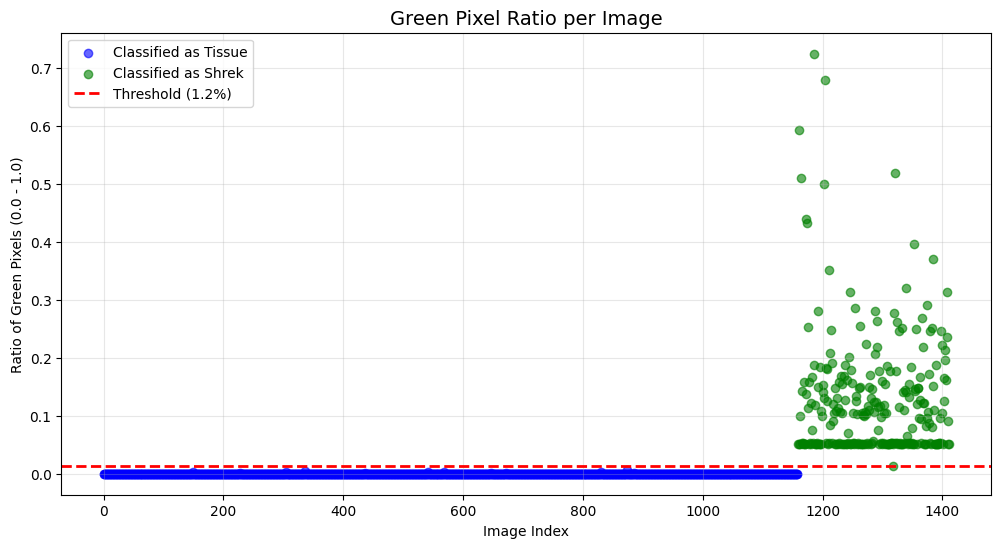

In [196]:
shrek_list, tissue_list = analyze_dataset(DATASET_PATH)

print(f"Classified {len(shrek_list)} as Shrek")
print(f"Classified {len(tissue_list)} as Tissue")

# Save Shrek images
print(f"Saving {len(shrek_list)} Shrek images to {SHREK_DIR}...")
for item in shrek_list:
    try:
        shutil.copy2(item['path'], os.path.join(SHREK_DIR, item['name']))
    except Exception as e:
        print(f"Error copying {item['name']} to shrek folder: {e}")

# Save Tissue images
print(f"Saving {len(tissue_list)} Tissue images to {TISSUE_DIR}...")
for item in tissue_list:
    try:
        shutil.copy2(item['path'], os.path.join(TISSUE_DIR, item['name']))
    except Exception as e:
        print(f"Error copying {item['name']} to tissue folder: {e}")

# 2. Visualize Examples (2x2 Grid)
if len(shrek_list) >= 2 and len(tissue_list) >= 2:
    fig_ex, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig_ex.suptitle(f"Classification Results (Threshold: {RATIO_THRESHOLD:.1%})", fontsize=16)

    def show_img(ax, item, label):
        ax.imshow(item['img'])
        # Show the Green Ratio in the title so you can see WHY it was classified
        ax.set_title(f"{label}\n{item['name']}\nGreen Pixels: {item['ratio']:.2%}")
        ax.axis('off')

    # Row 1: Detected Shrek
    show_img(axes[0, 0], shrek_list[0], "Detected Shrek")
    show_img(axes[0, 1], shrek_list[1], "Detected Shrek")
    
    # Row 2: Detected Tissue
    show_img(axes[1, 0], tissue_list[0], "Detected Tissue")
    show_img(axes[1, 1], tissue_list[1], "Detected Tissue")

    plt.tight_layout()
    plt.show()
else:
    print("Not enough images in one or both classes to generate 2x2 sample grid.")

# 3. Plot Scatter Distribution for Tuning
shrek_ratios = [x['ratio'] for x in shrek_list]
tissue_ratios = [x['ratio'] for x in tissue_list]

plt.figure(figsize=(12, 6))

# Plot Tissue points (Blue)
plt.scatter(range(len(tissue_ratios)), tissue_ratios, color='blue', alpha=0.6, label='Classified as Tissue')

# Plot Shrek points (Green) - Shifted on x-axis to be distinct
plt.scatter(range(len(tissue_ratios), len(tissue_ratios) + len(shrek_ratios)), shrek_ratios, color='green', alpha=0.6, label='Classified as Shrek')

# Draw the Threshold Line
plt.axhline(y=RATIO_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold ({RATIO_THRESHOLD:.1%})')

plt.title('Green Pixel Ratio per Image', fontsize=14)
plt.ylabel('Ratio of Green Pixels (0.0 - 1.0)')
plt.xlabel('Image Index')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



## Image Inspection

In [197]:
def inspect_image(filename):
    """
    Visualizes the Sophisticated Mask and calculated ratio for a single specific image.
    """
    filepath = os.path.join(DATASET_PATH, filename)
    if not os.path.exists(filepath):
        print(f"Error: {filename} not found in {DATASET_PATH}")
        return

    img = cv2.imread(filepath)
    if img is None:
        print("Error: Could not load image.")
        return

    # Prepare for filter
    img_rgb_norm = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply Filter
    result_bgr, mask = filter_bright_green_areas(img_rgb_norm)

    # Calculate Stats
    total_pixels = img.shape[0] * img.shape[1]
    green_pixels = np.count_nonzero(mask)
    ratio = green_pixels / total_pixels
    
    is_shrek = ratio > RATIO_THRESHOLD
    classification = "SHREK" if is_shrek else "TISSUE"
    
    # Print stats to console
    print(f"--- Inspection: {filename} ---")
    print(f"Green Pixels:   {ratio:.4%}")
    print(f"Threshold:      {RATIO_THRESHOLD:.4%}")
    print(f"Classification: {classification}")
    print("-" * 30)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.imshow(img_rgb)
    ax1.set_title(f"Original: {filename}")
    ax1.axis('off')
    
    ax2.imshow(mask, cmap='gray')
    ax2.set_title(f"Sophisticated Mask (Ratio: {ratio:.4%})\nThreshold: {RATIO_THRESHOLD:.1%}\nClassified as: {classification}")
    ax2.axis('off')
    
    plt.suptitle(f"Specific Inspection for {filename}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Example Usage: Uncomment and change the filename to test


--- Inspection: img_0104.png ---
Green Pixels:   59.2200%
Threshold:      1.2500%
Classification: SHREK
------------------------------


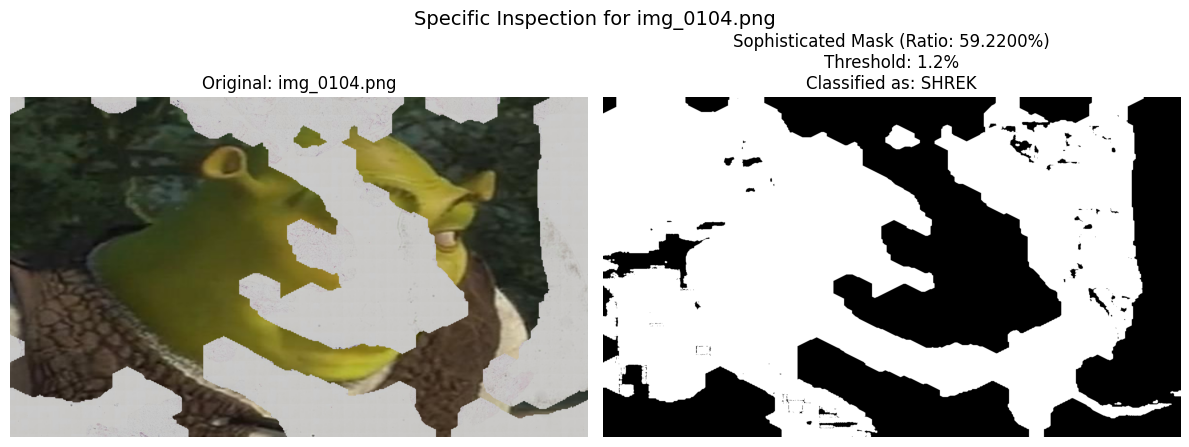

In [198]:
inspect_image('img_0104.png')

--- Inspection: img_0203.png ---
Green Pixels:   43.2511%
Threshold:      1.2500%
Classification: SHREK
------------------------------


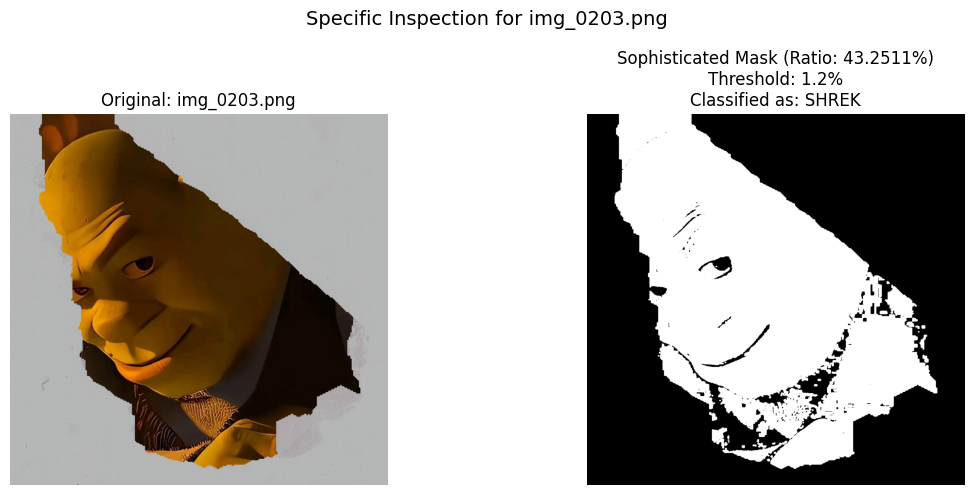

In [199]:
inspect_image('img_0203.png')